# Machine Learning with the CF data.

Can we predict either FEV1 directly or probably FEV1 class

In [1]:
import os
import sys

import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns
import json

from itertools import cycle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error

from scipy.stats import linregress


# there is a FutureWarning in sklearn StandardScalar which is really annoying. This ignores it.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

try:
  import google.colab
  IN_COLAB = True
  !pip install adjustText
  from google.colab import drive
  drive.mount('/content/drive')
  datadir = '/content/drive/MyDrive/Projects/CF/Adelaide/CF_Data_Analysis'
except ImportError:
  IN_COLAB = False
  datadir = '..'

from adjustText import adjust_text

from socket import gethostname
hostname = gethostname()
if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False

import cf_analysis_lib

In [2]:
sequence_type = "MGI"
taxa = 'genus'
datadir = '..'
bacterial_pathogens = cf_analysis_lib.BacterialPathogens()
pathogens = bacterial_pathogens.get_taxonomic_levels(taxa)

metadata = cf_analysis_lib.read_metadata(datadir, sequence_type)
metadata.head()

df = cf_analysis_lib.read_taxonomy(datadir, sequence_type, taxa)
df = df.T
df = df.rename_axis('NAME')
df

taxonomy,Aegiribacteria,Kapaibacterium,Stahlbacteria,Vermiphilus,Babela,Chromulinivorax,Ozemobacter,Desulfacyla,Dissulfurimicrobium,Dissulfurirhabdus,...,Oceaniferula,Persicirhabdus,Phragmitibacter,Prosthecobacter,Roseibacillus,Roseimicrobium,Sulfuriroseicoccus,Verrucomicrobium,Eremiobacter,Methylomirabilis
NAME,,,,,,,,,,,,,,,,,,,,,
1068841_20180306_S,0.0,0.0,0.539042,0.0,0.0,0.0,0.0,0.0,0.269521,0.000000,...,1.347606,0.0,0.0,0.0,0.539042,0.0,0.0,0.539042,0.000000,0.000000
1085876_20180227_S,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.850518,0.0,0.0,0.850518,0.283506,0.283506
1128691_20171206_S,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,7.166532,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
1128691_20171218_S,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,11.285217,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
1128691_20180116_S,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895293_20180502_S,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2.302092,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
896213_20180427_S,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,15.980057,0.000000,0.000000
913873_20180417_S,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000


In [3]:
# prompt: I have df with the counts of different bacteria, and metadata with the different data. How do I build a machine learning model to identify which different bacteria from df are best at predicting the values in FEV1_RATIO_SCORE in metadata? Both my data frames have a column called Pseudomonas, and I want to call the one from metadata "Culture Pseudomonas"

# Merge the dataframes
merged_df = df.join(metadata[['FEV1_RATIO_SCORE']])

# this data set models just the pathogens
#X = merged_df[list(pathogens)] # Features (bacteria counts)
#y = merged_df['FEV1_RATIO_SCORE'] # Target variable

# this data set models all bacteria
X = merged_df.drop('FEV1_RATIO_SCORE', axis=1)
y = merged_df['FEV1_RATIO_SCORE']

# Handle missing values (if any) - replace with mean for simplicity
X = X.fillna(X.mean())
y = y.fillna(y.mean())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a RandomForestRegressor model
model = RandomForestRegressor(random_state=42, n_estimators = 100) # You can adjust hyperparameters
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Feature importance
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances_sorted = feature_importances.sort_values(ascending=False)
print("\nFeature Importance:")
feature_importances_sorted

Mean Squared Error: 0.6027259734153846

Feature Importance:


Blautia              0.028744
Frondihabitans       0.025050
Commensalibacter     0.015653
Xanthomonas          0.014272
Jatrophihabitans     0.012149
                       ...   
Leadbetterella       0.000000
Marinilongibacter    0.000000
Persicitalea         0.000000
Pseudarcicella       0.000000
Methylomirabilis     0.000000
Length: 3581, dtype: float64

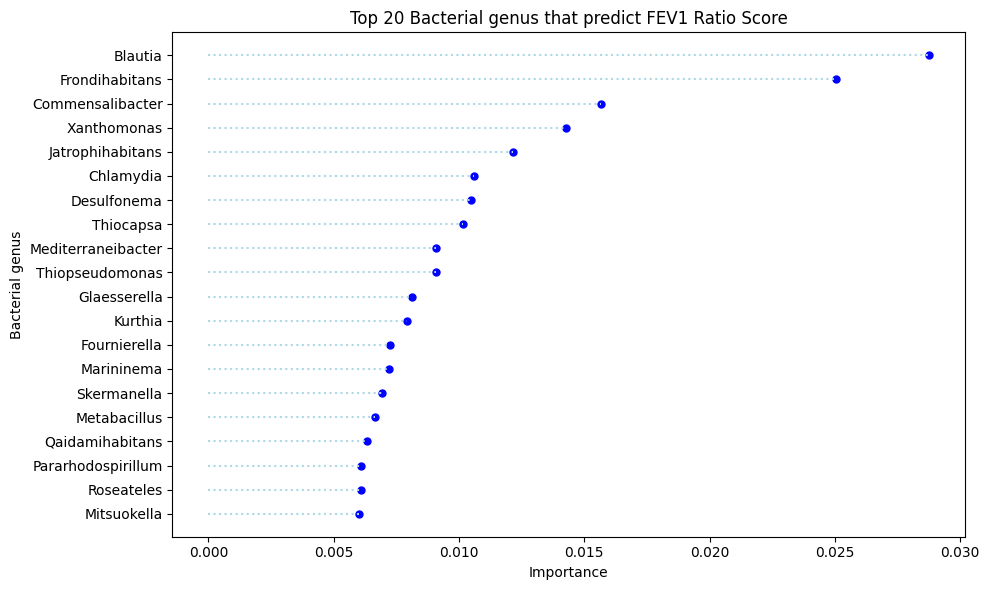

In [4]:
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
top_20_features = feature_importances_sorted.head(20)[::-1]

# Create dotted lines and circles for each feature
for feature, importance in top_20_features.items():
    # plt.plot([0, importance], [feature, feature], linestyle='dotted', marker='o', markersize=5)
    plt.plot([importance], [feature], linestyle='dotted', marker='o', markersize=5, c='blue')
    plt.plot([0, importance], [feature, feature], linestyle='dotted', marker='None', markersize=5, c='lightblue')

plt.xlabel("Importance")
plt.ylabel(f"Bacterial {taxa}")
plt.title(f"Top 20 Bacterial {taxa} that predict FEV1 Ratio Score")
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

## Predict FEV1 Ratio Score Using Pathogenic Bacteria

# Predict FEV1 using pathogenic bacteria

Mean Squared Error for all bacteria: 0.0029689638236442242
Mean Squared Error for pathogenic bacteria: 0.0024163996639587873


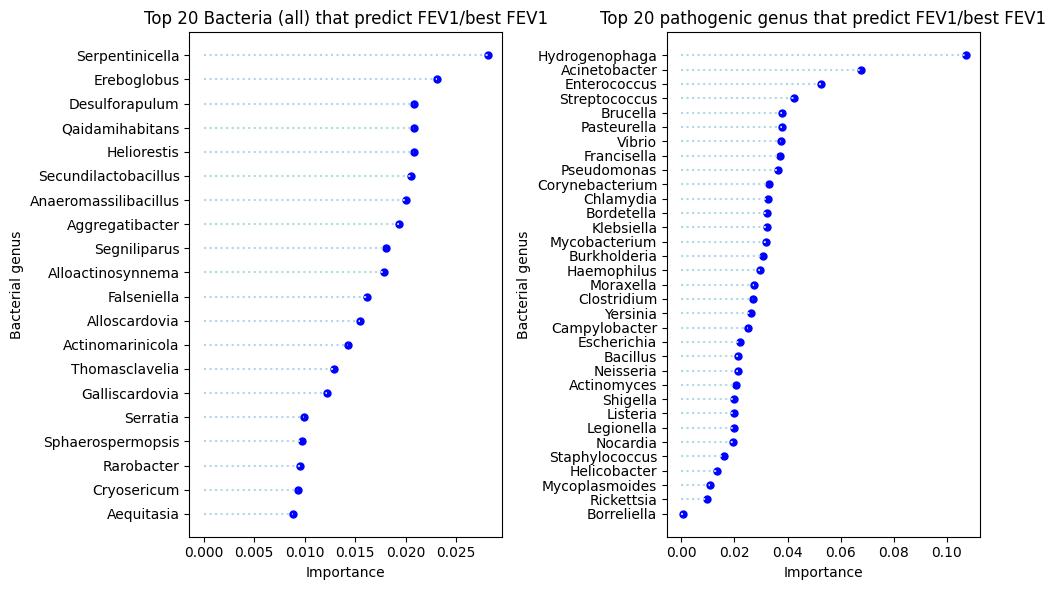

In [5]:
# Merge the dataframes
intcol = 'FEV1/best FEV1' # interesting column!
merged_df = df.join(metadata[[intcol]])

# this data set models all bacteria
X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

# Handle missing values (if any) - replace with mean for simplicity
X = X.fillna(X.mean())
y = y.fillna(y.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(random_state=42, n_estimators = 1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error for all bacteria: {mse}")

# Feature importance
feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance'])
feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)

fig, axes = plt.subplots(figsize=(10,6), nrows=1, ncols=2)

# Create dotted lines and circles for each feature
for feature in feature_importances_sorted.index[:20][::-1]:
    importance = feature_importances_sorted.loc[feature, 'importance']
    axes[0].plot([importance], [feature], linestyle='dotted', marker='o', markersize=5, c='blue')
    axes[0].plot([0, importance], [feature, feature], linestyle='dotted', marker='None', markersize=5, c='lightblue')

axes[0].set_xlabel("Importance")
axes[0].set_ylabel(f"Bacterial {taxa}")
axes[0].set_title(f"Top 20 Bacteria (all) that predict {intcol}")





# this data set models just the pathogens
X = merged_df[list(pathogens)] # Features (bacteria counts)
y = merged_df[intcol] # Target variable

# this data set models all bacteria
#X = merged_df.drop(intcol, axis=1)
#y = merged_df[intcol]

# Handle missing values (if any) - replace with mean for simplicity
X = X.fillna(X.mean())
y = y.fillna(y.mean())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error for pathogenic bacteria: {mse}")

# Feature importance
feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance'])
feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)

# Create dotted lines and circles for each feature
for feature in feature_importances_sorted.index[::-1]:
    importance = feature_importances_sorted.loc[feature, 'importance']
    axes[1].plot([importance], [feature], linestyle='dotted', marker='o', markersize=5, c='blue')
    axes[1].plot([0, importance], [feature, feature], linestyle='dotted', marker='None', markersize=5, c='lightblue')

axes[1].set_xlabel("Importance")
axes[1].set_ylabel(f"Bacterial {taxa}")
axes[1].set_title(f"Top 20 pathogenic {taxa} that predict {intcol}")



plt.tight_layout()
plt.show()

Mean Squared Error: 0.5521500915692307


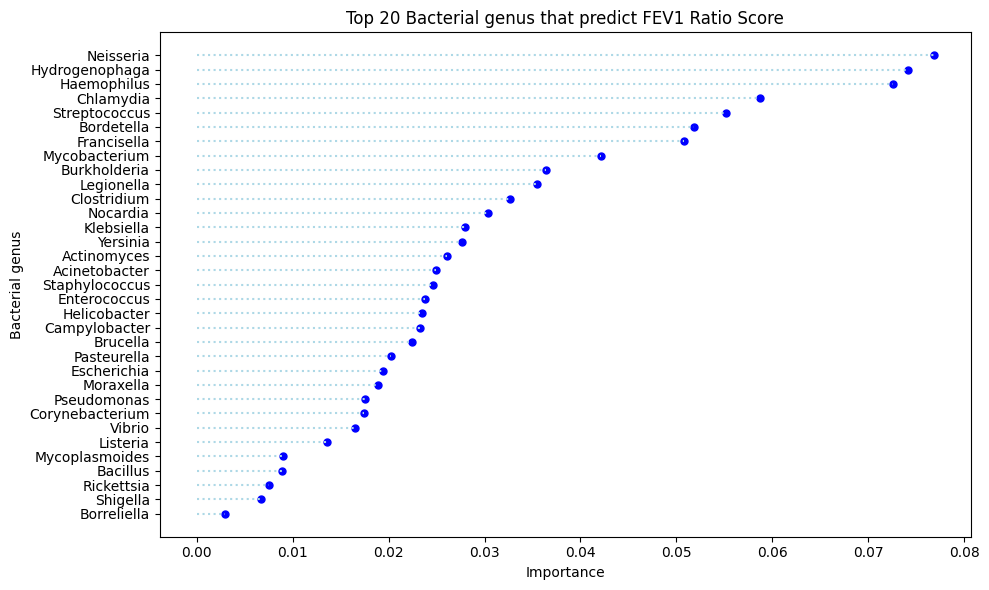

In [6]:
# Merge the dataframes
merged_df = df.join(metadata[['FEV1_RATIO_SCORE']])

# this data set models just the pathogens
X = merged_df[list(pathogens)] # Features (bacteria counts)
y = merged_df['FEV1_RATIO_SCORE'] # Target variable

# this data set models all bacteria
#X = merged_df.drop('FEV1_RATIO_SCORE', axis=1)
#y = merged_df['FEV1_RATIO_SCORE']

# Handle missing values (if any) - replace with mean for simplicity
X = X.fillna(X.mean())
y = y.fillna(y.mean())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a RandomForestRegressor model
model = RandomForestRegressor(random_state=42, n_estimators = 100) # You can adjust hyperparameters
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Feature importance
feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance'])
feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
# Create dotted lines and circles for each feature
for feature in feature_importances_sorted.index[::-1]:
    importance = feature_importances_sorted.loc[feature, 'importance']
    plt.plot([importance], [feature], linestyle='dotted', marker='o', markersize=5, c='blue')
    plt.plot([0, importance], [feature, feature], linestyle='dotted', marker='None', markersize=5, c='lightblue')

plt.xlabel("Importance")
plt.ylabel(f"Bacterial {taxa}")
plt.title(f"Top 20 Bacterial {taxa} that predict FEV1 Ratio Score")
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [7]:
"', '".join(list(metadata.columns))

"minion', 'MGI', 'pwCF_ID', 'Sample date', 'IP vs OP', 'Hospital', 'Room', 'Age', 'Age groups', 'Paediatric vs Adult', 'Gender', 'Sample_Type', 'H2_Uncorrected', 'CH4_Uncorrected', 'CO2', 'H2_Corrected', 'CH4_Corrected', 'CH4/H2 ratio_corrected', 'Corr.', 'Culture Result (Matched with sequenced sample)', 'NTM', 'Pseudomonas Culture', 'Cutured in previous 12 months', 'Others cultured', 'IgE', 'Spec IgE', 'Spec IgG', 'Precipitins', 'FVC', 'FEV1', 'Best FEV1', 'FEV1/best FEV1', 'FEV1_RATIO_SCORE', 'FEV1_Obstruction_Rank', 'Cystic Fibrosis related diabetes (CFRD)', 'Pancreatic insufficiency (PI)', 'CF gene 1', 'CF gene 2', 'Notes', 'CFLD', 'CS_mucoid', 'CS_non-mucoid', 'CS_Pseudomonas aeruginosa', 'CS_Oral flora', 'CS_Stenophotomonas maltophilia', 'CS_Aspergillus fumigatus', 'CS_Aspergillus flavus', 'CS_Candida albicans', 'CS_Mycobacteroides abscessus', 'CS_Mycobacterium intracellulare', 'CS_Staphylococcus  aureus', 'CS_Inquilinus limosus', 'CS_Achromobacter xylosoxidans', 'CS_Burkholderia

In [8]:
all_interesting_cols = ['IP vs OP', 'Hospital', 'Room', 'Age', 'Age groups', 'Paediatric vs Adult', 'Gender',
              'H2_Corrected', 'CH4_Corrected', 'CH4/H2 ratio_corrected', 'NTM', 'Pseudomonas Culture',
              'IgE', 'Spec IgE', 'Spec IgG', 'Precipitins', 'FVC', 'FEV1', 'Best FEV1', 'FEV1/best FEV1',
              'FEV1_RATIO_SCORE', 'FEV1_Obstruction_Rank', 'Cystic Fibrosis related diabetes (CFRD)',
              'Pancreatic insufficiency (PI)']

allintcols = [x for x in all_interesting_cols if pd.api.types.is_numeric_dtype(metadata[x])]
print(allintcols)

['Age', 'Age groups', 'H2_Corrected', 'CH4_Corrected', 'CH4/H2 ratio_corrected', 'NTM', 'Pseudomonas Culture', 'IgE', 'Spec IgE', 'Precipitins', 'FVC', 'FEV1', 'Best FEV1', 'FEV1/best FEV1', 'FEV1_RATIO_SCORE', 'FEV1_Obstruction_Rank']


IP vs OP
Model Accuracy for using pathogenic bacteria to predict IP vs OP: -0.00
Mean Squared Error for using pathogenic bacteria to predict IP vs OP: 0.23
Hospital
Model Accuracy for using pathogenic bacteria to predict Hospital: 0.24
Mean Squared Error for using pathogenic bacteria to predict Hospital: 0.16
Room
Model Accuracy for using pathogenic bacteria to predict Room: 0.03
Mean Squared Error for using pathogenic bacteria to predict Room: 196.91
Age
Model Accuracy for using pathogenic bacteria to predict Age: 0.17
Mean Squared Error for using pathogenic bacteria to predict Age: 113.13
Age groups
Model Accuracy for using pathogenic bacteria to predict Age groups: 0.24
Mean Squared Error for using pathogenic bacteria to predict Age groups: 1.40
Paediatric vs Adult
Model Accuracy for using pathogenic bacteria to predict Paediatric vs Adult: 0.20
Mean Squared Error for using pathogenic bacteria to predict Paediatric vs Adult: 0.17
Gender
Model Accuracy for using pathogenic bacteria t

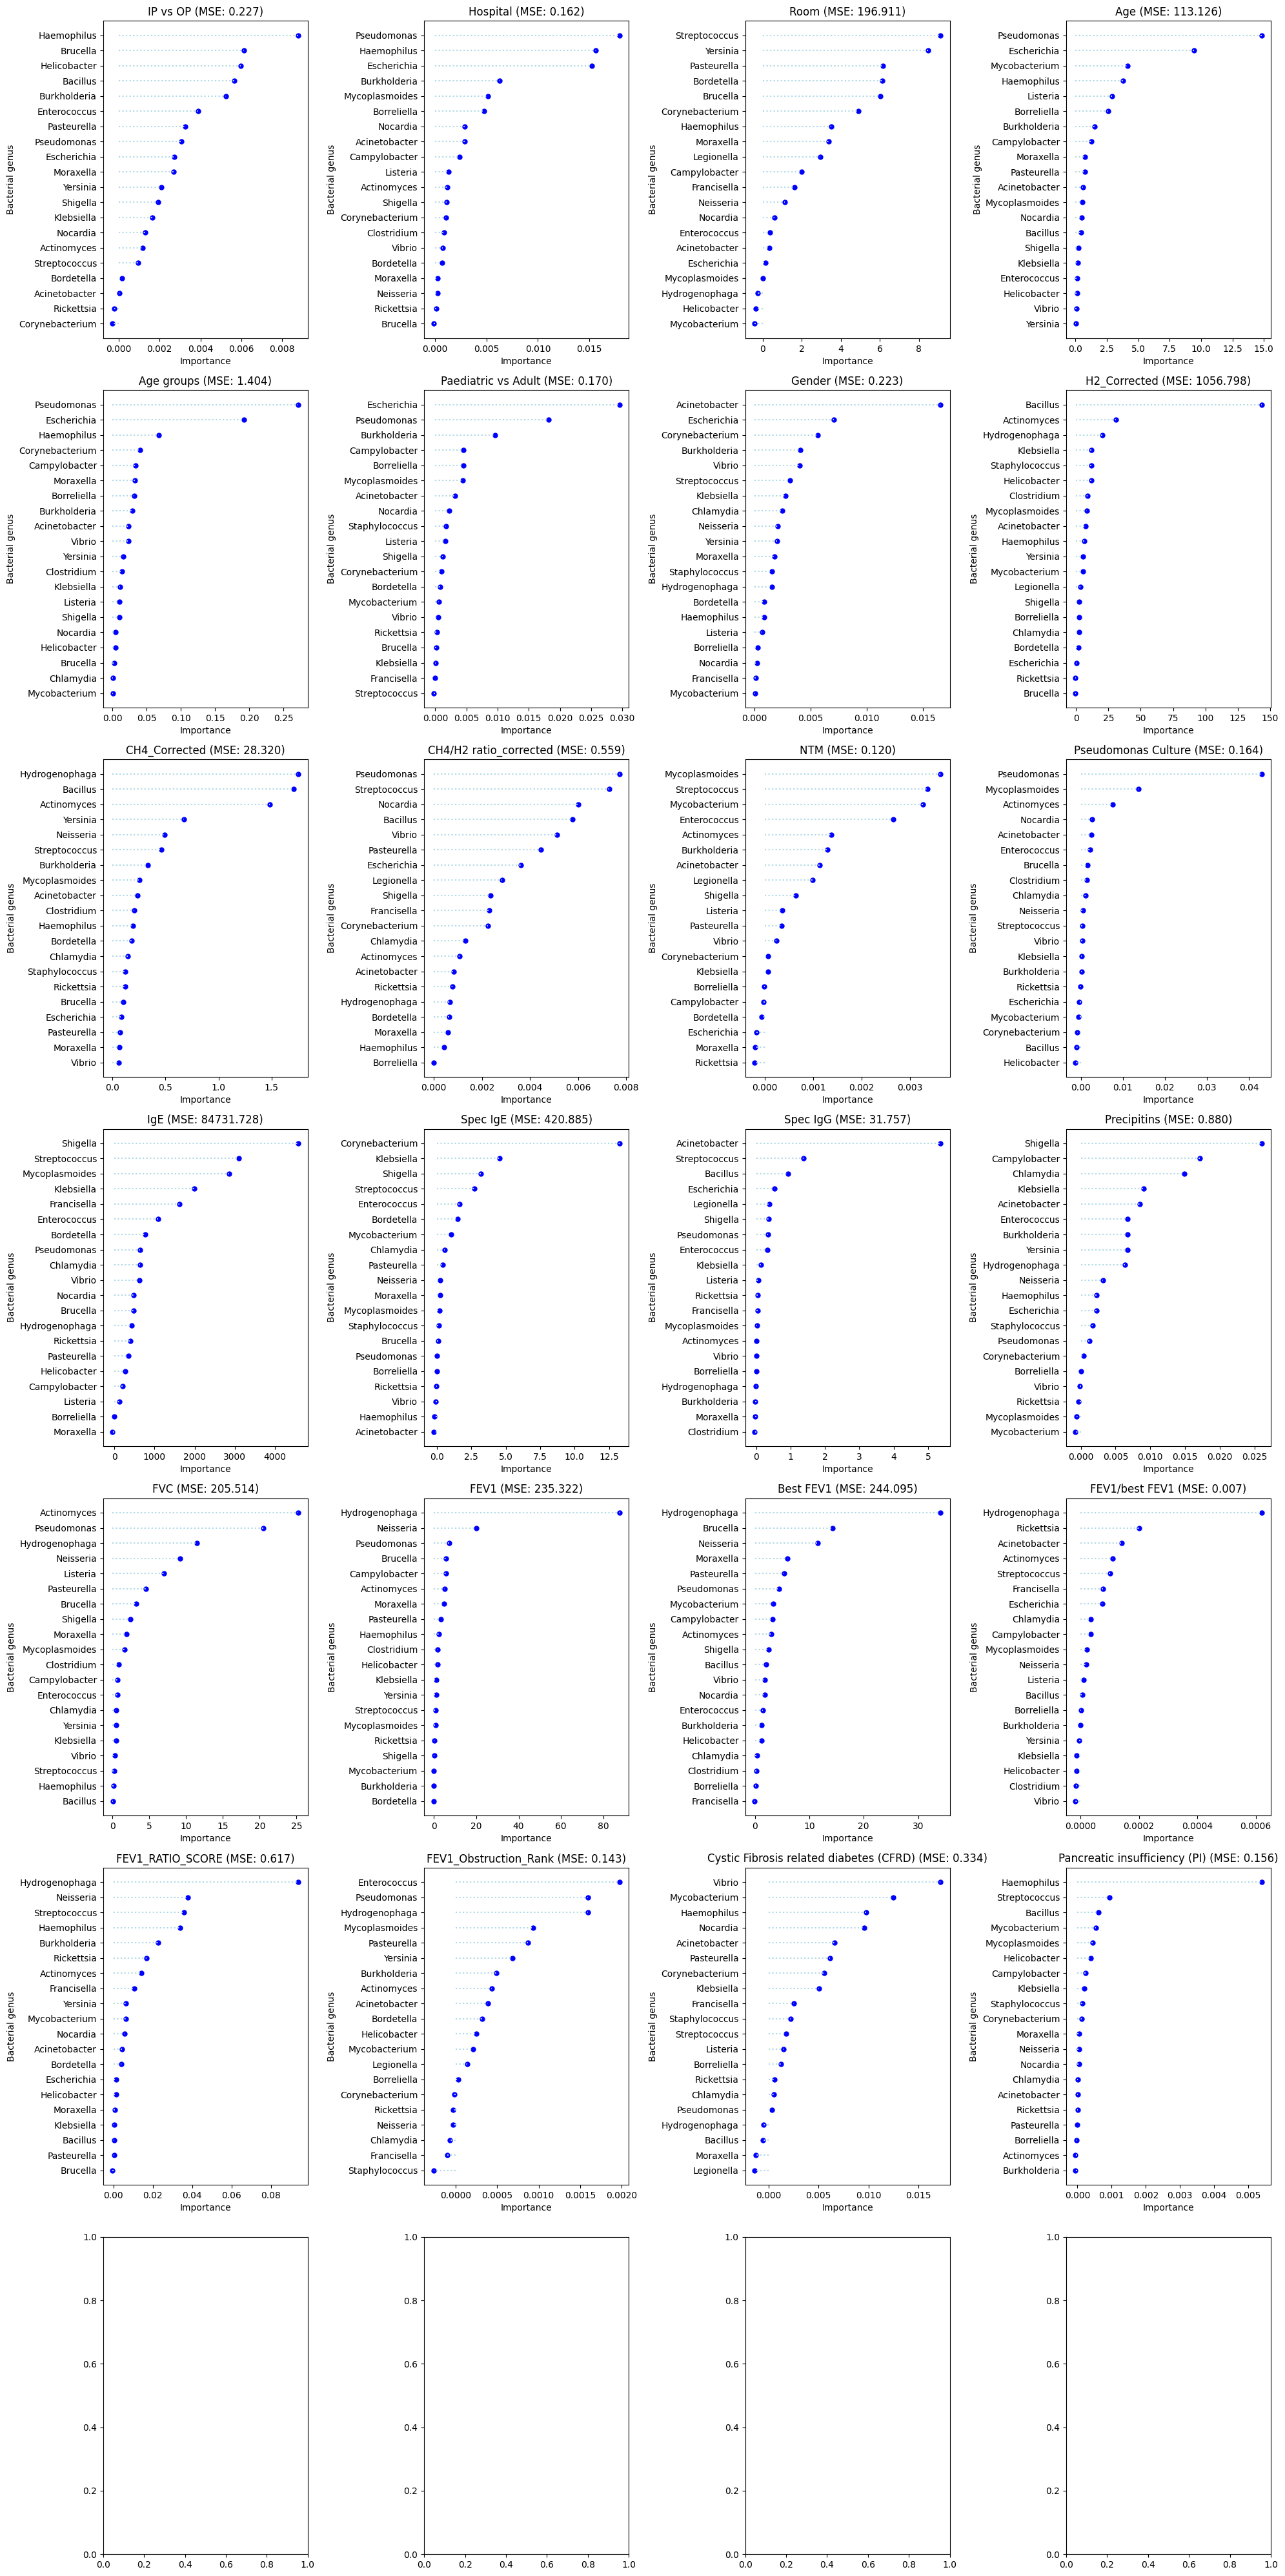

In [9]:
allintcols = all_interesting_cols
numrows = len(allintcols)//4 + 1

fig, axes = plt.subplots(figsize=(20,40), nrows=numrows, ncols=4)
model = RandomForestRegressor(random_state=42, n_estimators = 1000)
label_encoder = LabelEncoder()

for i, intcol in enumerate(allintcols):
  print(intcol)
  ax = axes[i//4, i%4]

  if metadata[intcol].dtype == 'object':
    m = metadata[[intcol]].copy()
    m["enc"] = label_encoder.fit_transform(m[intcol])
    merged_df = df.join(m[["enc"]].dropna(), how='inner')
    merged_df = merged_df.rename(columns={"enc": intcol})
  else:
    merged_df = df.join(metadata[[intcol]].dropna(), how='inner')



  # this data set models just the pathogens
  X = merged_df[list(pathogens)] # Features (bacteria counts)
  y = merged_df[intcol] # Target variable

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  accuracy = model.score(X_test, y_test)
  print(f"Model Accuracy for using pathogenic bacteria to predict {intcol}: {accuracy:.2f}")

  mse = mean_squared_error(y_test, y_pred)
  print(f"Mean Squared Error for using pathogenic bacteria to predict {intcol}: {mse:.2f}")



  # Feature importance
  # This is the default method
  # feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance'])
  # this alternative method uses the permutation importance which _should_ be comparable across models?
  pim = permutation_importance(model, X_test, y_test, scoring='neg_mean_squared_error')
  #pim = permutation_importance(model, X_test, y_test, scoring='accuracy', random_state=42)
  # choose a scoring method for regression OR classification. See https://scikit-learn.org/1.5/modules/model_evaluation.html#common-cases-predefined-values
  #pim = permutation_importance(model, X_test, y_test, scoring='explained_variance', random_state=42)
  #print(f"Permutation importance Using MSE: {pimmse} Using accuracy: {pim}")
  feature_importances = pd.DataFrame(pim.importances_mean, index=X.columns, columns=['importance'])
  feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)

  # Create dotted lines and circles for each feature
  for feature in feature_importances_sorted.index[:20][::-1]:
      importance = feature_importances_sorted.loc[feature, 'importance']
      ax.plot([importance], [feature], linestyle='dotted', marker='o', markersize=5, c='blue')
      ax.plot([0, importance], [feature, feature], linestyle='dotted', marker='None', markersize=5, c='lightblue')

  ax.set_xlabel("Importance")
  ax.set_ylabel(f"Bacterial {taxa}")
  ax.set_title(f"{intcol} (MSE: {mse:.3f})")


plt.tight_layout()
plt.show()


## Testing permutation importance using _Pseudomonas_

Mean Squared Error for all bacteria: 0.1967448846153846
Model Accuracy for using pathogenic bacteria to predict Pseudomonas Culture: -0.11


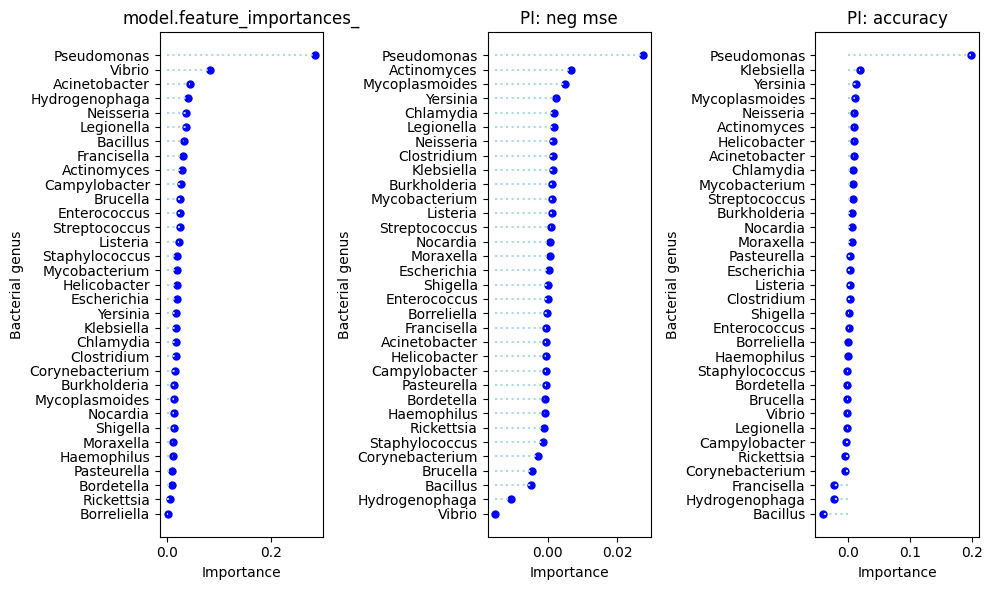

In [10]:
# Merge the dataframes
intcol = 'Pseudomonas Culture' # interesting column!
merged_df = df.join(metadata[[intcol]].astype('category').dropna())

X = merged_df[list(pathogens)]
y = merged_df[intcol].cat.codes

# this data set models all bacteria
#X = merged_df.drop(intcol, axis=1

# Handle missing values (if any) - replace with mean for simplicity
X = X.fillna(X.mean())
y = y.fillna(y.mean())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(random_state=42, n_estimators = 1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error for all bacteria: {mse}")

accuracy = model.score(X_test, y_test)
print(f"Model Accuracy for using pathogenic bacteria to predict {intcol}: {accuracy:.2f}")


fig, axes = plt.subplots(figsize=(10,6), nrows=1, ncols=3)

# Feature importance
feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance'])
feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)

# Create dotted lines and circles for each feature
for feature in feature_importances_sorted.index[::-1]:
    importance = feature_importances_sorted.loc[feature, 'importance']
    axes[0].plot([importance], [feature], linestyle='dotted', marker='o', markersize=5, c='blue')
    axes[0].plot([0, importance], [feature, feature], linestyle='dotted', marker='None', markersize=5, c='lightblue')

axes[0].set_xlabel("Importance")
axes[0].set_ylabel(f"Bacterial {taxa}")
axes[0].set_title(f"model.feature_importances_")

# permutation importance

pim = permutation_importance(model, X_test, y_test, scoring='neg_mean_squared_error')
feature_importances = pd.DataFrame(pim.importances_mean, index=X.columns, columns=['importance'])
feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)

# Create dotted lines and circles for each feature
for feature in feature_importances_sorted.index[::-1]:
    importance = feature_importances_sorted.loc[feature, 'importance']
    axes[1].plot([importance], [feature], linestyle='dotted', marker='o', markersize=5, c='blue')
    axes[1].plot([feature_importances_sorted.min()[0], importance], [feature, feature], linestyle='dotted', marker='None', markersize=5, c='lightblue')

axes[1].set_xlabel("Importance")
axes[1].set_ylabel(f"Bacterial {taxa}")
axes[1].set_title(f"PI: neg mse")


# permutation importance


pim = permutation_importance(model, X_test, y_test, scoring='d2_absolute_error_score', random_state=42)
feature_importances = pd.DataFrame(pim.importances_mean, index=X.columns, columns=['importance'])
feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)

# Create dotted lines and circles for each feature
for feature in feature_importances_sorted.index[::-1]:
    importance = feature_importances_sorted.loc[feature, 'importance']
    axes[2].plot([importance], [feature], linestyle='dotted', marker='o', markersize=5, c='blue')
    axes[2].plot([0, importance], [feature, feature], linestyle='dotted', marker='None', markersize=5, c='lightblue')

axes[2].set_xlabel("Importance")
axes[2].set_ylabel(f"Bacterial {taxa}")
axes[2].set_title(f"PI: accuracy")

plt.tight_layout()
plt.show()

# Random Forest Classifier

The above is with a _REGRESSOR_ not a classifier

Mean Squared Error for all bacteria: 0.23076923076923078
Model Accuracy for using pathogenic bacteria to predict Pseudomonas Culture: 0.77


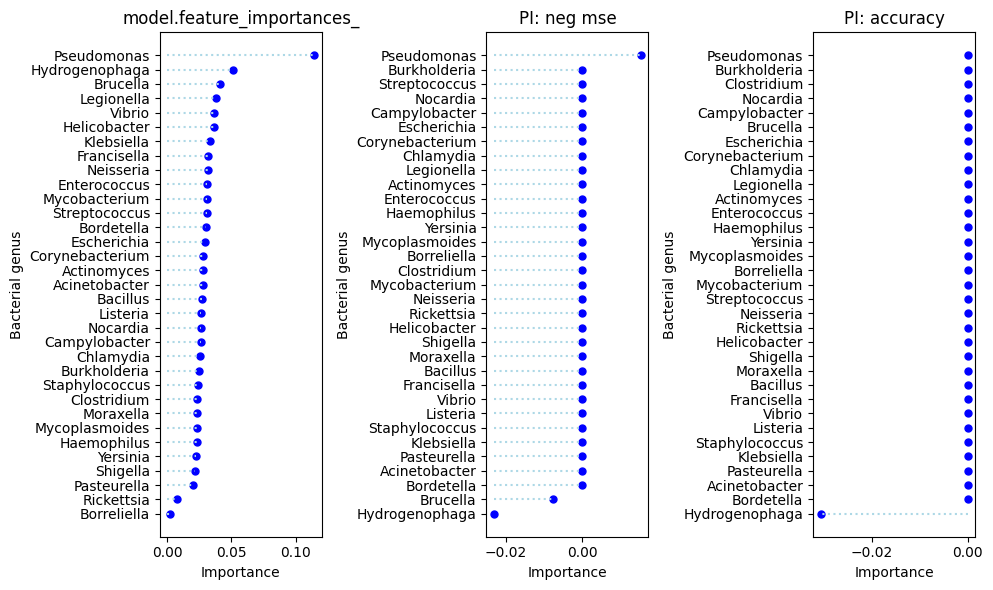

In [11]:
# Merge the dataframes
intcol = 'Pseudomonas Culture' # interesting column!
merged_df = df.join(metadata[[intcol]].astype('category').dropna())

X = merged_df[list(pathogens)]
y = merged_df[intcol]

# this data set models all bacteria
#X = merged_df.drop(intcol, axis=1

# Handle missing values (if any) - replace with mean for simplicity
X = X.fillna(0)
y = y.fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(random_state=42, n_estimators = 1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error for all bacteria: {mse}")

accuracy = model.score(X_test, y_test)
print(f"Model Accuracy for using pathogenic bacteria to predict {intcol}: {accuracy:.2f}")


fig, axes = plt.subplots(figsize=(10,6), nrows=1, ncols=3)

# Feature importance
feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance'])
feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)

# Create dotted lines and circles for each feature
for feature in feature_importances_sorted.index[::-1]:
    importance = feature_importances_sorted.loc[feature, 'importance']
    axes[0].plot([importance], [feature], linestyle='dotted', marker='o', markersize=5, c='blue')
    axes[0].plot([0, importance], [feature, feature], linestyle='dotted', marker='None', markersize=5, c='lightblue')

axes[0].set_xlabel("Importance")
axes[0].set_ylabel(f"Bacterial {taxa}")
axes[0].set_title(f"model.feature_importances_")

# permutation importance

pim = permutation_importance(model, X_test, y_test, scoring='neg_mean_squared_error')
feature_importances = pd.DataFrame(pim.importances_mean, index=X.columns, columns=['importance'])
feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)

# Create dotted lines and circles for each feature
for feature in feature_importances_sorted.index[::-1]:
    importance = feature_importances_sorted.loc[feature, 'importance']
    axes[1].plot([importance], [feature], linestyle='dotted', marker='o', markersize=5, c='blue')
    axes[1].plot([feature_importances_sorted.min()[0], importance], [feature, feature], linestyle='dotted', marker='None', markersize=5, c='lightblue')

axes[1].set_xlabel("Importance")
axes[1].set_ylabel(f"Bacterial {taxa}")
axes[1].set_title(f"PI: neg mse")


# permutation importance


pim = permutation_importance(model, X_test, y_test, scoring='accuracy', random_state=42)
feature_importances = pd.DataFrame(pim.importances_mean, index=X.columns, columns=['importance'])
feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)

# Create dotted lines and circles for each feature
for feature in feature_importances_sorted.index[::-1]:
    importance = feature_importances_sorted.loc[feature, 'importance']
    axes[2].plot([importance], [feature], linestyle='dotted', marker='o', markersize=5, c='blue')
    axes[2].plot([0, importance], [feature, feature], linestyle='dotted', marker='None', markersize=5, c='lightblue')

axes[2].set_xlabel("Importance")
axes[2].set_ylabel(f"Bacterial {taxa}")
axes[2].set_title(f"PI: accuracy")

plt.tight_layout()
plt.show()

In [12]:
print(y.unique())  # Check the unique values in the target
print(y.dtypes)

[0.0, 1.0]
Categories (2, float64): [0.0, 1.0]
category


In [13]:
y

NAME
1068841_20180306_S    0.0
1085876_20180227_S    1.0
1128691_20171206_S    1.0
1128691_20171218_S    1.0
1128691_20180116_S    1.0
                     ... 
895293_20180502_S     1.0
896213_20180427_S     0.0
913873_20180417_S     0.0
980574_20180403_S     1.0
983493_20180123_S     1.0
Name: Pseudomonas Culture, Length: 127, dtype: category
Categories (2, float64): [0.0, 1.0]

In [14]:
feature_importances

,importance
Burkholderia,0.000000e+00
Streptococcus,0.000000e+00
Acinetobacter,0.000000e+00
Pasteurella,0.000000e+00
Klebsiella,0.000000e+00
Staphylococcus,0.000000e+00
Listeria,0.000000e+00
Vibrio,0.000000e+00
Francisella,0.000000e+00
Bacillus,0.000000e+00
